In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import time
import timeit
from sklearn.linear_model import LinearRegression
from numba import cuda
import math

# get the sparse matrix A and vector f we use in the wave problem
def time_harmonic_wave(N):
    # define parameter
    h = 1 / N
    k = 29 * np.pi / 2
    n_elements = (N - 1) * 3 + 2
    row_ind = np.empty(n_elements, dtype=np.float64)
    col_ind = np.empty(n_elements, dtype=np.float64)
    data = np.empty(n_elements, dtype=np.float64)
    f = np.zeros(N + 1, dtype=np.float64)

    # Assign values to the arrays
    f[-1] = 1
    count = 0
    for i in range(N + 1):
        if i == 0 or i == N:
            row_ind[count] = col_ind[count] = i
            data[count] = 1
            count = count + 1
        else:
            row_ind[count:count + 3] = i
            col_ind[count:count + 3] = np.arange(i - 1, i + 2)
            data[count] = data[count + 2] = -1
            data[count + 1] = 2 - (h ** 2) * (k ** 2)
            count = count + 3
    return coo_matrix((data, (row_ind, col_ind)), shape=(N + 1, N + 1)).tocsr(), f


# get the final time‘s temperature vector of x of the rod,
# this function allows the input N to be large
def heat_equation_vector(N, t):
    h = 1 / N
    iter_time = N * t
    u = np.zeros(N + 1)
    u[0] = 10
    u[-1] = 10
    for itr in range(1, iter_time + 1):
        u_last = u
        for i in range(1, N):
            u[i] = u_last[i] + (1 / (1000 * h)) * (u_last[i - 1] - 2 * u_last[i] + u_last[i + 1])
    return u


# get the whole process matrix (u(x,t) = temperature),
# this function can not receive large input N (may cause overflow problem although type is float64)
def heat_equation_matrix(N, t):
    h = 1 / N
    x_size = N + 1
    t_size = N * t + 1
    u = np.zeros((x_size, t_size))
    u[0, :] = u[N, :] = 10
    for itr in range(1, t_size):
        for x in range(1, x_size - 1):
            u[x, itr] = u[x, itr - 1] + (1 / (1000 * h)) * (u[x - 1, itr - 1] - 2 * u[x, itr - 1] + u[x + 1, itr - 1])
    return u


# By judging the GPU parallel thread index to replace a layer of for loops
@cuda.jit
def gpu_parallel_vector(N, u, u_last):
    idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if idx < N - 1:
        u[idx + 1] = u_last[idx + 1] + (1 / (1000 * (1 / N))) * (u_last[idx] - 2 * u_last[idx + 1] + u_last[idx + 2])


@cuda.jit
def gpu_parallel_matrix(N, u, itr):
    idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if 0 < idx < N:
        u[idx, itr] = u[idx, itr - 1] + (1 / (1000 * (1 / N))) * (
                u[idx - 1, itr - 1] - 2 * u[idx, itr - 1] + u[idx + 1, itr - 1])


# GPU implementation of heat_equation_vector
def heat_equation_vector_gpu(N, t):
    iter_times = N * t
    u = np.zeros(N + 1)
    u[0] = 10
    u[-1] = 10
    u_device = cuda.to_device(u)
    threads_per_block = 4
    blocks_per_grid = math.ceil((N - 1) / threads_per_block)
    # the iterative loop cannot be parallelized, keep it
    for itr in range(1, iter_times + 1):
        u_last_device = u_device
        gpu_parallel_vector[blocks_per_grid, threads_per_block](N, u_device, u_last_device)

    u = u_device.copy_to_host()

    return u


# GPU implementation of heat_equation_matrix
def heat_equation_matrix_gpu(N, t):
    x_size = N + 1
    t_size = N * t + 1
    u = np.zeros((x_size, t_size))
    u[0, :] = u[N, :] = 10
    u_device = cuda.to_device(u)
    threads_per_block = 4
    blocks_per_grid = math.ceil((N - 1) / threads_per_block)
    # the iterative loop cannot be parallelized, keep it
    for itr in range(1, t_size):
        gpu_parallel_matrix[blocks_per_grid, threads_per_block](N, u_device, itr)

    u = u_device.copy_to_host()
    return u

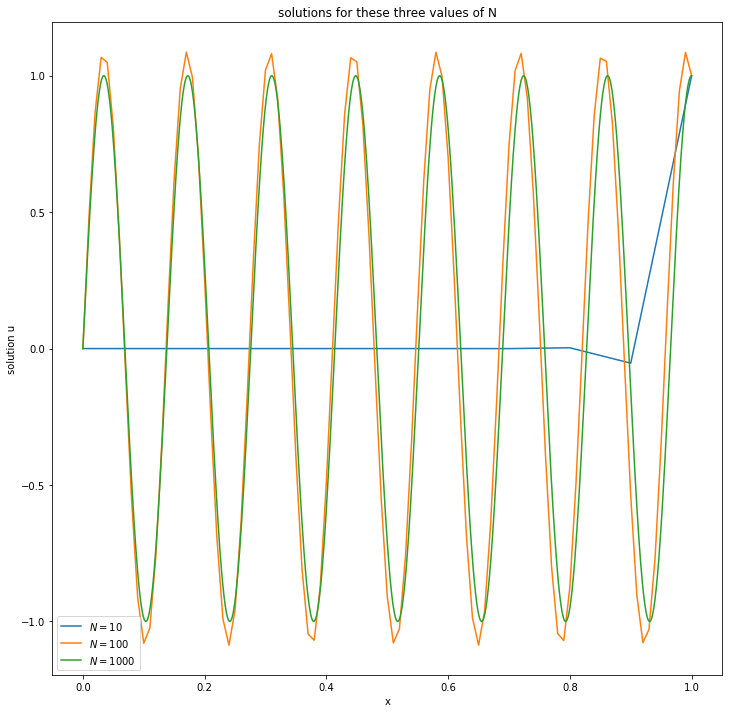

In [ ]:
# ----------  part1  ----------

# plot the solutions for these three values of N
plt.figure(figsize = (12,12))
N = [10, 100, 1000]
for n in N:
    A, f = time_harmonic_wave(n)
    u = spsolve(A, f)
    plt.plot(np.linspace(0, 1, n + 1), u, label='$N= %d$' % n)

plt.legend()
plt.title("solutions for these three values of N")
plt.xlabel('x')
plt.ylabel('solution u')
plt.show()

According to the figure obtained from my experiments, when N = 10, its solution line is just a straight line shape, which does not look much related to the waves. When N = 100, the solution line has a similar trend to the wave, but it is not smooth enough. When N = 1000, the solution line has a wave shape, which is similar to the trend of the sin function.

For this figure analysis, the larger N is, the closer the image is to the actual solution of the wave problem. When **N = 1000**, I expect it to be closest to the actual solution of the wave problem.

In [ ]:
# error and executing time of the solutions
N = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000]
error_log_arr = []
time_log_arr = []
# ignore the effect of spsolve preparation on the results
A, f = time_harmonic_wave(100)
u = spsolve(A, f)
for n in N:
    start_time = time.time()
    A, f = time_harmonic_wave(n)
    u = spsolve(A, f)
    end_time = time.time()
    u_exact = [np.sin((29 * np.pi / 2) * x) for x in np.linspace(0, 1, n + 1)]
    error_log = np.log10(np.max(np.abs(u - u_exact)))
    error_log_arr.append(error_log)
    time_log_arr.append(np.log10(end_time - start_time))

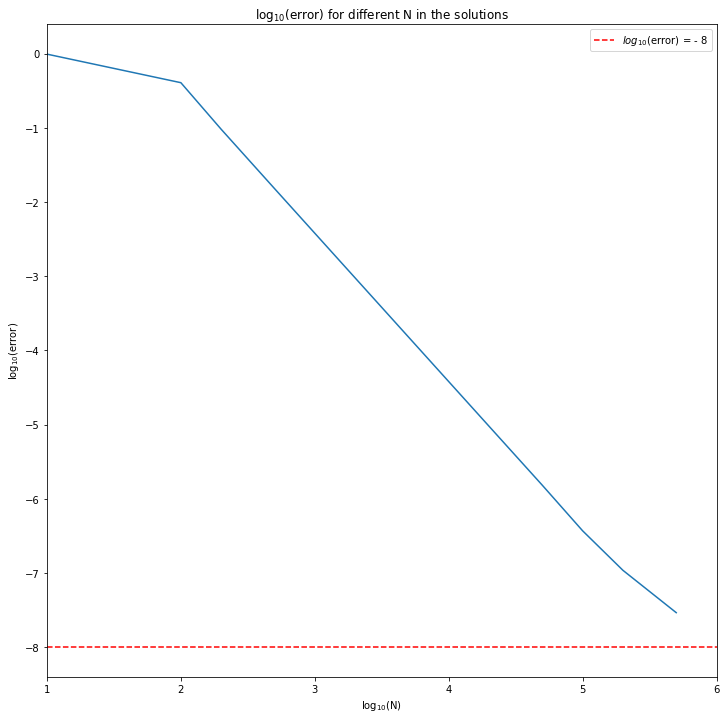

In [ ]:
# plot N against the error in my solution
plt.figure(figsize = (12,12))
plt.plot(np.log10(N), error_log_arr)
plt.axhline(y=-8, color='r', linestyle='--', label='$log_{10}$(error) = - 8')
plt.legend()
plt.title("$\\log_{10}$(error) for different N in the solutions")
plt.xlim(1, 6)
plt.xlabel('$\\log_{10}$(N)')
plt.ylabel('$\\log_{10}$(error)')
plt.show()

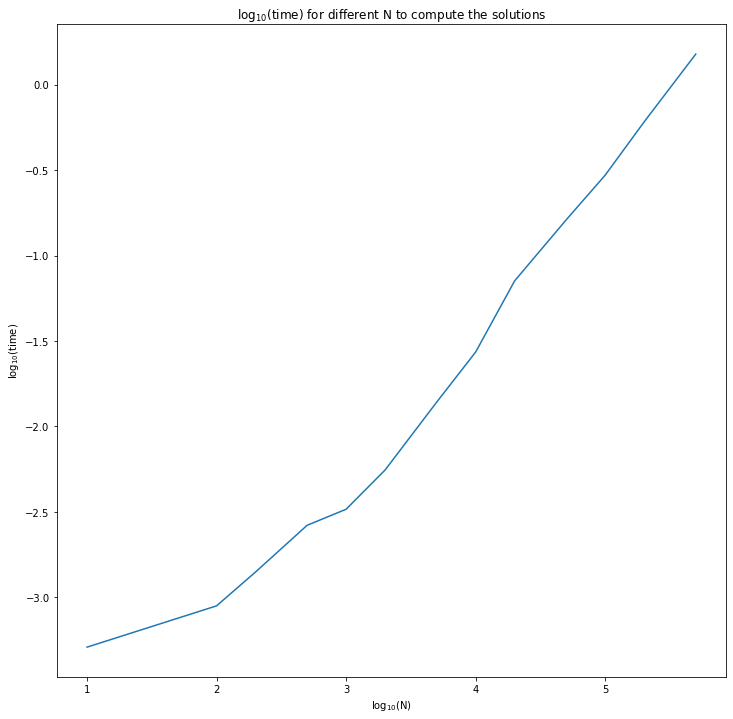

In [ ]:
# plot N against the time taken to compute a solution
plt.figure(figsize = (12,12))
plt.plot(np.log10(N), time_log_arr)
plt.title("$\\log_{10}$(time) for different N to compute the solutions")
plt.xlabel('$\\log_{10}$(N)')
plt.ylabel('$\\log_{10}$(time)')
plt.show()

In [ ]:
# I use unary linear regression to pick a value of N which will give error of 10^{-8}
# and predict how long the computation will take
x_train = np.log10(np.array(N[2:]).reshape((len(N[2:]), 1)))
y_train_error = np.array(error_log_arr[2:]).reshape((len(error_log_arr[2:]), 1))
y_train_time = np.array(time_log_arr[2:]).reshape((len(time_log_arr[2:]), 1))
linearModel_error = LinearRegression()
linearModel_time = LinearRegression()
linearModel_error.fit(x_train, y_train_error)
linearModel_time.fit(x_train, y_train_time)
a = linearModel_error.coef_[0][0]
b = linearModel_error.intercept_[0]
n_predict = round(10 ** ((-8 - b) / a))
c = linearModel_time.coef_[0][0]
d = linearModel_time.intercept_[0]
n_predict_time = 10**(((-8 - b) / a) * c + d)
print("predict N = %d" % n_predict)
print("predict N expected computation time = %f s" % n_predict_time)

predict N = 700579
predict N expected computation time = 1.763880 s


From the figures of error against N and time agianst N from my experiments, we can see that both figures are approximately unary linear changes (y = ax+b), so I use unary linear regression (fit) to pick N and predict its execution time. For the linear regression code, I invoke machine learning library sklearn to solve it.

Combining the two figures based on all the values I have chosen for N, it can be seen that the slope of the error and time versus N when N is 10, 100 is different than when N takes 200 to larger values. So I will not put the corresponding data when N is 10 and 100 in the training set during linear regression.

In [ ]:
# Compute the approximate solution with my value of N. Measure the time taken and the error.
start_time = time.time()
A, f = time_harmonic_wave(n_predict)
u = spsolve(A, f)
end_time = time.time()
print("the computation of predict n use %f s" % (end_time - start_time))
u_exact = [np.sin((29 * np.pi / 2) * x) for x in np.linspace(0, 1, n_predict + 1)]
error_log = np.log10(np.max(np.abs(u - u_exact)))
print("actual error = 10^%f" % error_log)

the computation of predict n use 2.153738 s
actual error = 10^-6.825661


selected N = 700579

actual computation time = 2.153738 > predict computation time = 1.763880

actual error = 10$^{-6.825661}$ > 10$^{-8}$

For the predicted N, my actual computation time is longer than the predicted computation time, but not too much longer (the training y value in the linear regression is log$_{10}$(time). When predicted a little bit difference, do the power of 10 to get the actual time(s) will be magnified), so the prediction belongs to the allowable range. The program is run in colab different code blocks, its possible that the result will also be affected by some background programs.

For the predict error, it is higher than 10$^{-8}$. In the following code I predict the change of error for successive N and plot a figure when N is taken to be larger (even to 10$^{7}$). In a comprehensive analysis, I think that there is an optimal value of N for the finite differences method to solve the wave problem, and our error is not monotonically decreasing as N gets larger. When the optimal value of N is passed, the error becomes progressively larger again. According to my tests, I obtained my smallest error (about 10$^{-7.8}$ > 10$^{-8}$ ) when N = 10$^{6}$, so my predicted N is not achievable smaller than 10$^{-8}$.


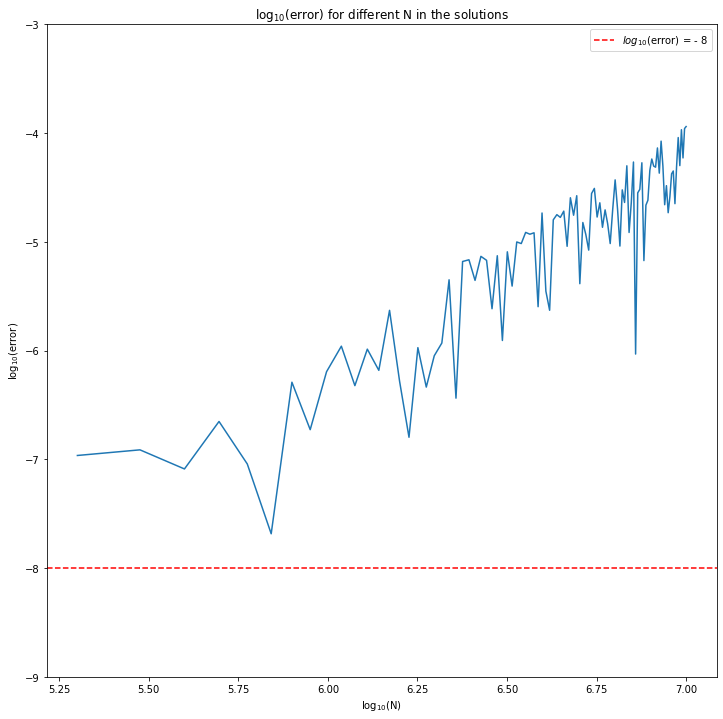

In [ ]:
# error actual trend figure when N in [200000,10000000] (use for analysis)
N = np.linspace(200000, 10000000, 100).astype(int)
error_log_arr = []
for n in N:
    A, f = time_harmonic_wave(n)
    u = spsolve(A, f)
    u_exact = [np.sin((29 * np.pi / 2) * x) for x in np.linspace(0, 1, n + 1)]
    error_log = np.log10(np.max(np.abs(u - u_exact)))
    error_log_arr.append(error_log)

plt.figure(figsize = (12,12))
plt.plot(np.log10(N), error_log_arr)
plt.axhline(y=-8, color='r', linestyle='--', label='$log_{10}$(error) = - 8')
plt.legend()
plt.ylim(-9, -3)
plt.title("$\\log_{10}$(error) for different N in the solutions")
plt.xlabel('$\\log_{10}$(N)')
plt.ylabel('$\\log_{10}$(error)')
plt.show()

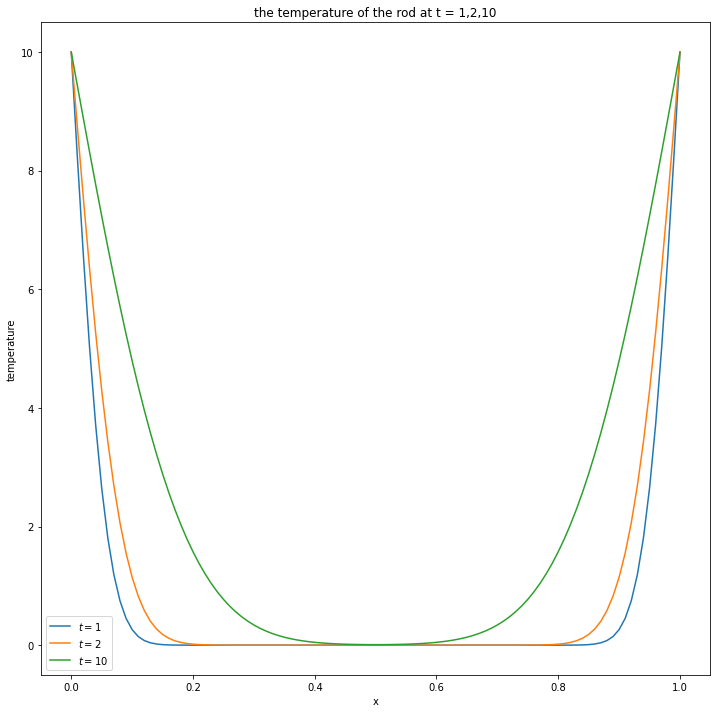

In [ ]:
# ----------  part2  ----------

# Implement of part2 iterative scheme is in function heat_equation_vector() and heat_equation_matrix()

# a sensible value of N
N = 100
t_arr = [1, 2, 10]
u_matrix_cpu = heat_equation_matrix(N, t_arr[-1])
x = np.linspace(0, 1, N + 1)
plt.figure(figsize = (12,12))
for t in t_arr:
    y = u_matrix_cpu[:, t * N]
    plt.plot(x, y, label='$t= %d$' % t)
plt.legend()
plt.title("the temperature of the rod at t = 1,2,10")
plt.xlabel('x')
plt.ylabel('temperature')
plt.show()

I chose the value of N to be 100.

Regarding the choice of the value of N, first, the time t in the figure we want to plot is 1, 2, and 10, respectively.   The values of these three t are not too large, so we have to choose a slightly larger N to evenly spaced x to more segments to see the change of each segment on rod over time.   In fact, at such a small time, the temperature in the middle of the rod has not changed much, so a larger N can make it easier to see the changes in other segents on the rod.

But N should not be taken too large, so let us analyze the equation of u(i , j + 1) given in part2.

if 500 =< N < 1000, when N = 500, u(i , j + 1) = 0.5 * u(i - 1 , j) + 0.5 * u(i + 1 , j)

In that case the temperature of the next time of a segment on rod is not related to the temperature of its own previous time, but only to the temperature of the previous time of its own neighboring segments, which is not in accordance with science. But according to the equation, it is still possible to conduct heat, and the middle segment of rod will eventually be heated continuously.

if N >= 1000, when N = 1000, u(i , j + 1) = u(i - 1 , j) + u(i + 1 , j) - u(i , j)

In that case, The coefficient in front of u(i, j) is -1, following the iterative process, heat will not be conducted.

In summary, we choose a compromise N， **N = 100**.

In [ ]:
# check if my gpu parallelise implementation results are correct, if not, print "Results are not equal"
N = 100
t = 10
u_cpu_matrix = heat_equation_matrix(N,t)
u_gpu_matrix = heat_equation_matrix_gpu(N,t)
assert np.allclose(u_cpu_matrix, u_gpu_matrix) == True, 'Results are not equal.'

In [ ]:
# Use numba.cuda to parallelise my implementation on a GPU
# function heat_equation_vector_gpu() and heat_equation_matrix_gpu()

# time comparison between cpu implementation and gpu implementation
N = 100
t = 1
print("N = %d , t = %d" % (N,t))
%timeit heat_equation_vector(N, t)
%timeit heat_equation_vector_gpu(N, t)
print("\n")
N = 100
t = 10
print("N = %d , t = %d" % (N,t))
%timeit heat_equation_vector(N, t)
%timeit heat_equation_vector_gpu(N, t)
print("\n")
N = 500
t = 100
print("N = %d , t = %d" % (N,t))
%timeit heat_equation_vector(N, t)
%timeit heat_equation_vector_gpu(N, t)

N = 100 , t = 1
8.62 ms ± 84.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.31 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


N = 100 , t = 10
85.6 ms ± 954 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
59 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


N = 500 , t = 100
22.4 s ± 709 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.97 s ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


By printing the time results, we see that the gpu parallel implementation is indeed faster than the cpu, and as N and t get larger, the faster is more pronounced and the less time is used.

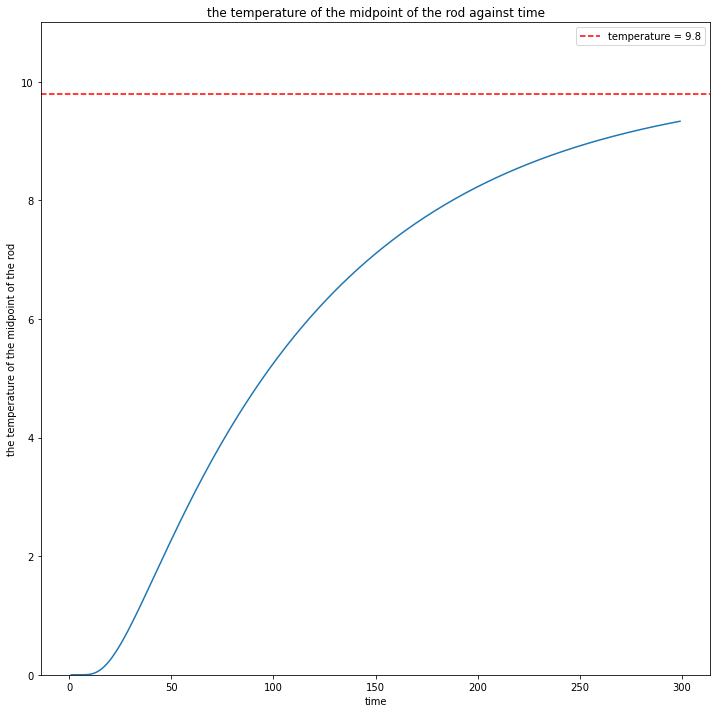

In [ ]:
# plot figure using for predict the time that the temperature of the midpoint of the rod first exceeds a temperature of 9.8
N = 100
t_arr = np.arange(1, 300)
tmp_arr = []
for t in t_arr:
    u_gpu = heat_equation_vector_gpu(N, t)
    tmp_arr.append(u_gpu[round(N / 2)])

plt.figure(figsize = (12,12))
plt.plot(t_arr, tmp_arr)
plt.axhline(y=9.8, color='r', linestyle='--', label='temperature = 9.8')
plt.title("the temperature of the midpoint of the rod against time")
plt.legend()
plt.xlabel('time')
plt.ylim(0, 11)
plt.ylabel('the temperature of the midpoint of the rod')
plt.show()

In [ ]:
# I use binary linear regression to estimate the time
# at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8

tmp_arr_square = [tmp*tmp for tmp in tmp_arr[200:]]
x_train = np.array(tmp_arr_square + tmp_arr[200:]).reshape((len(tmp_arr_square), 2), order="F")
y_train = np.array(t_arr[200:]).reshape((len(t_arr[200:]), 1))
linearModel = LinearRegression()
linearModel.fit(x_train, y_train)
a_arr = linearModel.coef_[0]
b = linearModel.intercept_[0]
time_estimate = round(a_arr[0] * (9.8**2) + a_arr[1] * 9.8 + b)
print("estimate time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8 = %d" % time_estimate)

estimate time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8 = 367


I plot figure of the temperature change of the rod midpoint as t increased from 0 to 300. Observing the figure of my experiment, interchanging the horizontal and vertical axes, the relationship between time and temperature is similar to the quadratic function (y = ax$^2$ + bx + c). By viewing the image, we see that when t = 300, the temperature has not yet reached 9.8. So I used a binary linear regression (fit) to predict this time. For the linear regression code, I invoke machine learning library sklearn to solve it.

In the later stages, the temperature rises slowly, because in the end it does not exceed 10.  So in the linear fit, my training x,y values are chosen only for the last 100 points of the figure, which for the value of t is from 200 to 300, so that the predicted quadratic function is more in line with the trend of the curve afterwards, and the predicted time will be more accurate.




In [ ]:
# calculate the actual time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8
N = 100
t_arr = np.arange(1, 1001)
for t in t_arr:
    u_gpu = heat_equation_vector_gpu(N, t)
    if u_gpu[round(N / 2)] > 9.8:
        print("the time that the temperature of the midpoint of the rod first exceeds a temperature of 9.8 = %d" % t)
        break

the time that the temperature of the midpoint of the rod first exceeds a temperature of 9.8 = 421


When the temperature of the midpoint of the rod first exceeds a temperature of 9.8, the actual t is larger than the t I predicted, but not much bigger, mainly because the trend of curve of the figure slows down as the final temperature approaches 10.(The actual value of t should be a decimal located in the interval from 420 to 421. Here, for convenience, we will express the value of t directly as an integer)